In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [2]:
# fetch data from Yahoo Finance
ticker = "^NDX"  # NASDAQ 100
data = yf.download(ticker, period="max", interval="1d")  # daily data
data.to_csv(f"{ticker}_data.csv")  # Save the data as a CSV file

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [12]:
data = pd.read_csv('^NDX_data.csv')

In [4]:
print(data.head())  # Display the first few rows of the data

        Price               Close                High                 Low  \
0      Ticker                ^NDX                ^NDX                ^NDX   
1        Date                 NaN                 NaN                 NaN   
2  1985-10-01  112.13999938964844  112.16000366210938  110.56500244140625   
3  1985-10-02  110.82499694824219  112.54000091552734  110.77999877929688   
4  1985-10-03  110.87000274658203  111.18499755859375  110.12000274658203   

                 Open     Volume  
0                ^NDX       ^NDX  
1                 NaN        NaN  
2  110.62000274658203  153160000  
3  112.13999938964844  164640000  
4  110.83999633789062  147300000  


In [5]:
print(data.info())  # Display information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9986 entries, 0 to 9985
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   9986 non-null   object
 1   Close   9985 non-null   object
 2   High    9985 non-null   object
 3   Low     9985 non-null   object
 4   Open    9985 non-null   object
 5   Volume  9985 non-null   object
dtypes: object(6)
memory usage: 468.2+ KB
None


In [6]:
print(data.describe())  # Display descriptive statistics of the data

             Price               Close                High  \
count         9986                9985                9985   
unique        9986                9836                9877   
top     2025-05-15  213.14500427246094  213.14500427246094   
freq             1                   3                   3   

                       Low                Open     Volume  
count                 9985                9985       9985  
unique                9866                9842       9614  
top     1529.4000244140625  213.14500427246094  258800000  
freq                     3                   3          5  


In [11]:
data

,Price,Close,High,Low,Open,Volume
0,Ticker,^NDX,^NDX,^NDX,^NDX,^NDX
1,Date,NaN,NaN,NaN,NaN,NaN
2,1985-10-01,112.13999938964844,112.16000366210938,110.56500244140625,110.62000274658203,153160000
3,1985-10-02,110.82499694824219,112.54000091552734,110.77999877929688,112.13999938964844,164640000
4,1985-10-03,110.87000274658203,111.18499755859375,110.12000274658203,110.83999633789062,147300000
...,...,...,...,...,...,...
9981,2025-05-09,20061.44921875,20203.580078125,19984.529296875,20170.369140625,8835140000
9982,2025-05-12,20868.150390625,20870.119140625,20613.26953125,20818.779296875,10717670000
9983,2025-05-13,21197.69921875,21259.390625,20891.1796875,20906.919921875,9242230000
9984,2025-05-14,21319.2109375,21336.48046875,21199.849609375,21254.470703125,11744820000


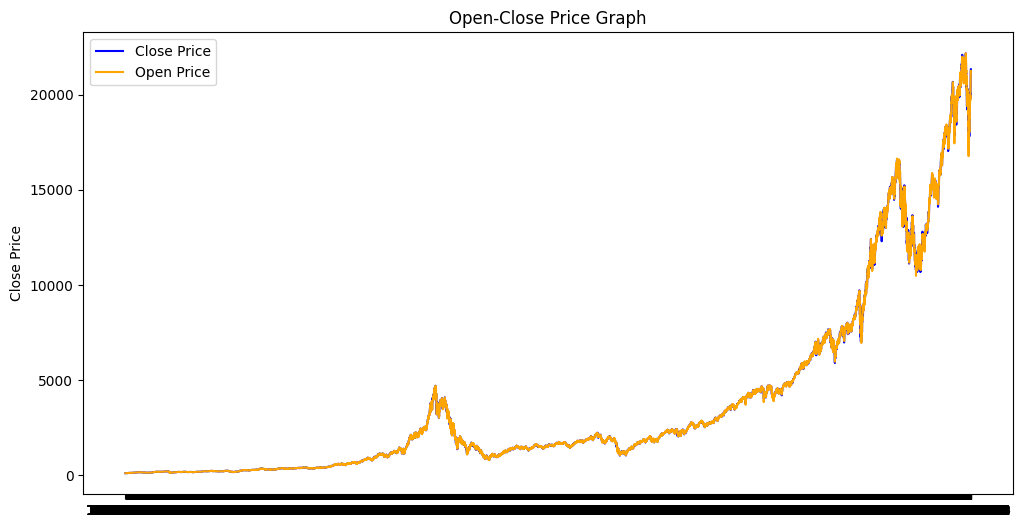

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
plt.plot(data['Date'], data['Open'], label='Open Price', color='orange')
plt.title('Open-Close Price Graph')
plt.ylabel('Close Price')
plt.legend()
plt.show()

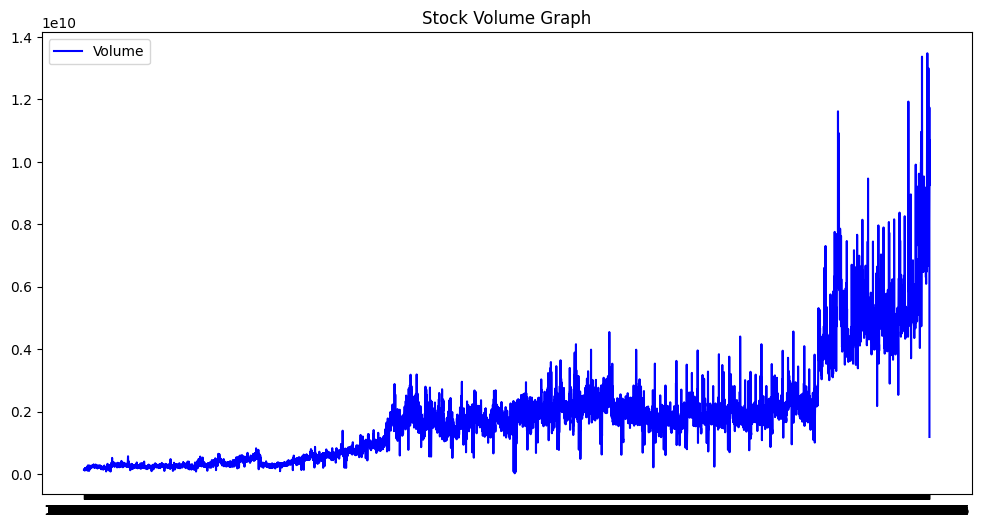

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Volume'], label='Volume', color='blue')
plt.title('Stock Volume Graph')
plt.legend()
plt.show()

In [15]:
numeric_data = data.select_dtypes(include=[np.number])

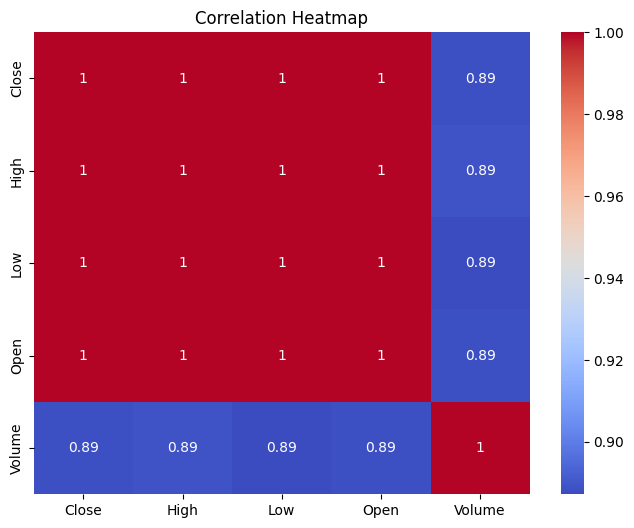

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [17]:
data['Date'] = pd.to_datetime(data['Date'])

In [18]:
prediction =data.loc[
    (data['Date'] >= '2020-01-01') & 
    (data['Date'] <= '2025-01-01')]

In [19]:
stock_close = data.filter(['Close'])
dataset = stock_close.values
training_data_len= int(np.ceil(len(dataset) * .95))

In [20]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [21]:
training_data = scaled_data[:training_data_len]

In [22]:
X_train, y_train = [], []

In [23]:
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])

In [24]:
X_train, y_train = np.array(X_train), np.array(y_train)


In [25]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [26]:
model = keras.models.Sequential()
# 1st layer
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# 2nd layer
model.add(keras.layers.LSTM(64, return_sequences=False))

# 3rd layer
model.add(keras.layers.Dense(128, activation='relu'))

# 4th layer
model.add(keras.layers.Dropout(0.5))

#final layer
model.add(keras.layers.Dense(1))

model.summary()  # Display the model summary
model.compile(optimizer='adam', loss=Huber(), metrics=[keras.metrics.RootMeanSquaredError()])

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [28]:
training=model.fit(X_train, y_train, epochs=120, batch_size=32, verbose=1)

Epoch 1/120
295/295 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0333 - root_mean_squared_error: 0.2437
Epoch 2/120
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0067 - root_mean_squared_error: 0.1155
Epoch 3/120
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0058 - root_mean_squared_error: 0.1079
Epoch 4/120
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0056 - root_mean_squared_error: 0.1062
Epoch 5/120
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0063 - root_mean_squared_error: 0.1121
Epoch 6/120
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0057 - root_mean_squared_error: 0.1064
Epoch 7/120
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0057 - root_mean_squared_error: 0.1062
Epoch 8/120
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0054 - root_mean_squared_error: 0.1043
Epoch 9/120
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0052 - root_mean_squared_error: 0.1018
Epoch 10/120
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0055 - r

In [29]:
model.save("lstm_model/ndx_lstm.h5")

import joblib
joblib.dump(scaler, "lstm_model/scaler.save")

['lstm_model/scaler.save']

KeyError: 'val_loss'

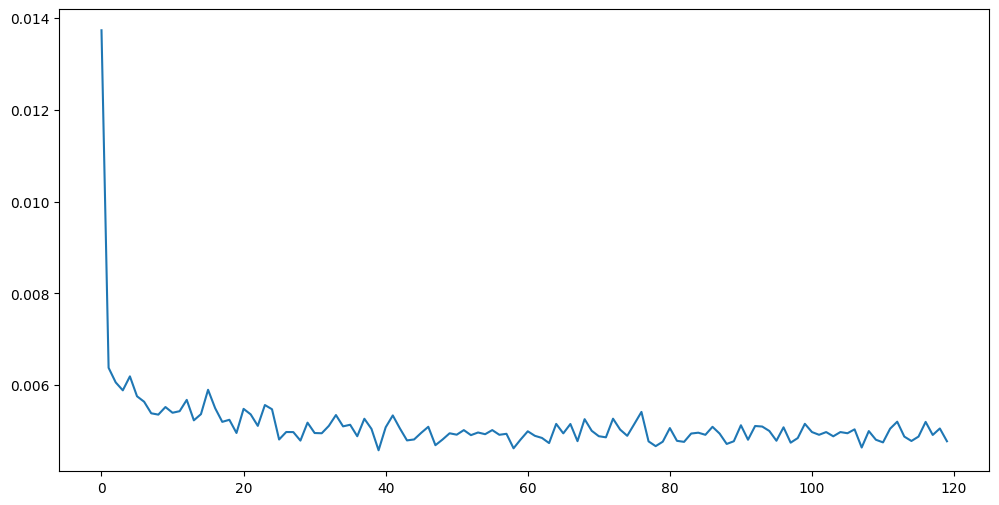

In [30]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(training.history['loss'], label='Train Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [31]:
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]

In [32]:
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [33]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [34]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse transform to get actual values

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [35]:
train = data[:training_data_len]
test = data[training_data_len:]
test = test.copy()

In [36]:
test['Predictions'] = predictions

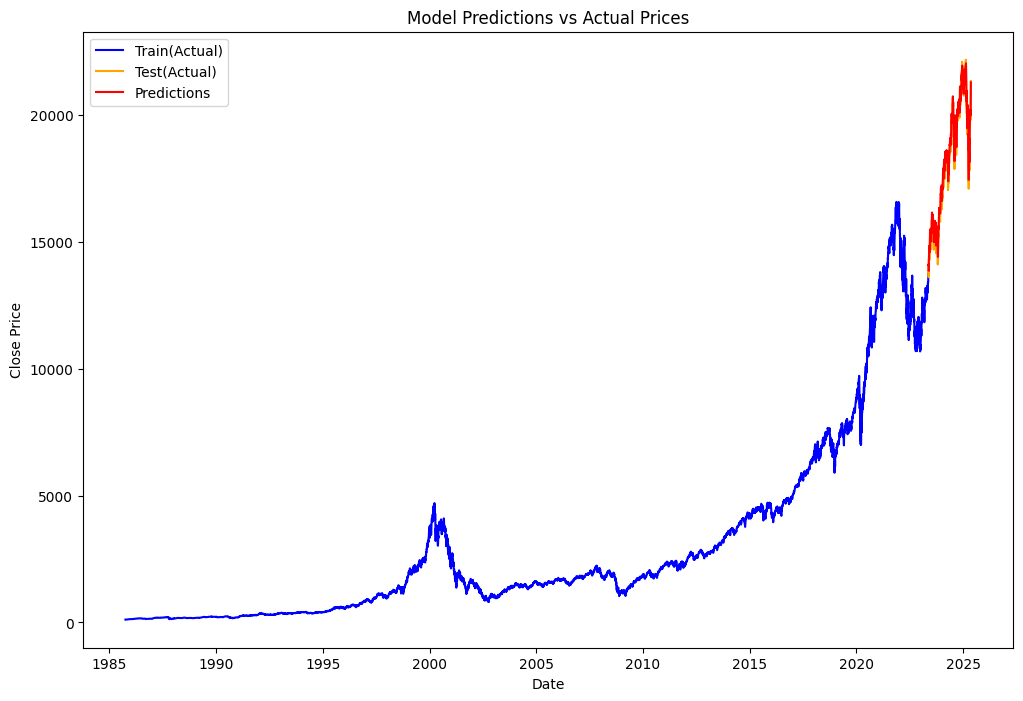

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(train['Date'], train['Close'], label='Train(Actual)', color='blue')
plt.plot(test['Date'], test['Close'], label='Test(Actual)', color='orange')
plt.plot(test['Date'], test['Predictions'], label='Predictions', color='red')
plt.title('Model Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

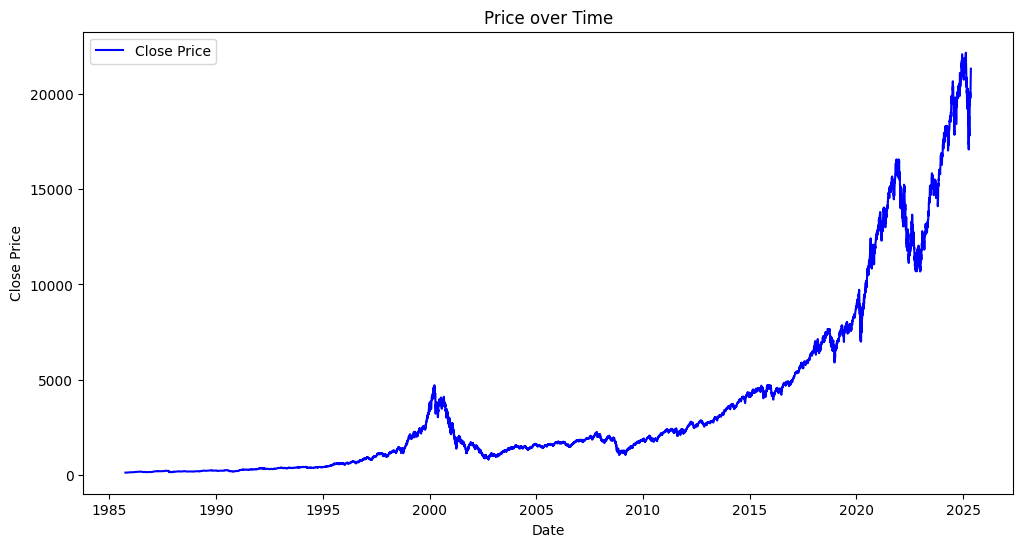

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
plt.title('Price over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [39]:
# Actual and predicted values
y_true = test['Close'].values
y_pred = test['Predictions'].values

# Evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
evs = explained_variance_score(y_true, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
directional_accuracy = np.mean((np.sign(np.diff(y_test.flatten())) == np.sign(np.diff(y_pred.flatten())))) * 100

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Explained Variance Score: {evs:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")


Mean Absolute Error (MAE): 263.1899
Mean Squared Error (MSE): 111093.9422
Root Mean Squared Error (RMSE): 333.3076
R^2 Score: 0.9789
Explained Variance Score: 0.9864
Mean Absolute Percentage Error: 14.7458
Directional Accuracy: 51.00%


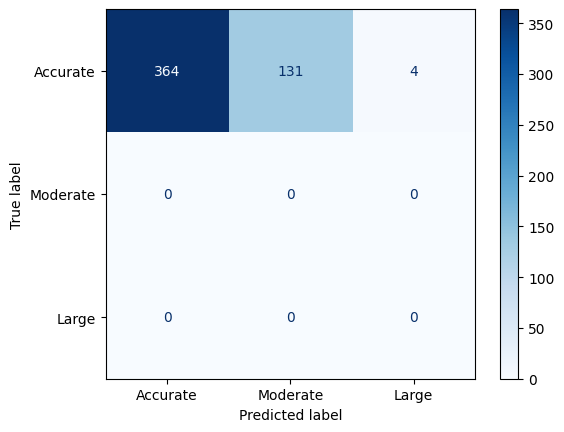

In [40]:
# Calculate percentage error
percent_error = np.abs((y_pred - y_true) / y_true) * 100

# Define bins
def categorize_error(error):
    if error < 2:
        return 'Accurate'
    elif error < 5:
        return 'Moderate'
    else:
        return 'Large'

y_true_bins = [categorize_error(0) for _ in y_true]  # Assume true label is always 'Accurate'
y_pred_bins = [categorize_error(err) for err in percent_error]

# Confusion matrix
cm = confusion_matrix(y_true_bins, y_pred_bins, labels=['Accurate', 'Moderate', 'Large'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Accurate', 'Moderate', 'Large'])
disp.plot(cmap='Blues')
